In [1]:
import os, sys
import numpy as np
import corner

sys.path.append('../')
import py21cmfish as p21fish

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.mathtext as mathtext

%matplotlib inline

plt.style.use(['default','seaborn','seaborn-ticks'])
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['figure.figsize'] = (4,3)
mpl.rcParams['figure.dpi'] = 150

if os.path.exists(os.environ['WORK_DIR']+'/code/matplotlibrc'):
    from matplotlib import rc_file
    rc_file(os.environ['WORK_DIR']+'/code/matplotlibrc')

    mathtext.FontConstantsBase.sup1 = 0.5
    mathtext.FontConstantsBase.sub1 = 0.2
    mathtext.FontConstantsBase.sub2 = 0.2

In [2]:
%load_ext autoreload
%autoreload 2

# 21cmfish examples

This notebook loads and plots example posteriors based on the 21cm power spectrum.

To run the notebook you must first unpack the data directories in `/examples/`

1. [EOS21 - CDM fiducial with pop II and pop III galaxies](#EOS21)
2. [Comparison with Park+19](#Comparison-to-Park+19)
3. [Adding your own new parameter](#Adding-a-new-parameter)

In [8]:
examples_dir = p21fish.base_path+'examples/'
data_dir     = examples_dir+'data/'
noise_dir    = data_dir+'21cmSense_noise/'

# EOS21

This is a fiducial case from [Munoz+2021](#) with CDM, and with both pop II and pop III galaxies.

In [4]:
# Find the parameters we varied and fiducials from the config file
# but you could also list these yourself (especially if you want to change the order)
astro_params_vary, astro_params_fid = p21fish.get_params_fid(
                                        config_file=p21fish.base_path+'21cmFAST_config_files/EoS_mini.config')

print('Varying parameters:',astro_params_vary)
print('Fiducial parameter values:',astro_params_fid)

assert type(astro_params_vary) == list, 'astro_params_vary must be a list'
assert type(astro_params_fid) == dict, 'astro_params_vary must be a dict'

Varying parameters: ['ALPHA_STAR', 'F_STAR10', 'ALPHA_ESC', 'F_ESC10', 'ALPHA_STAR_MINI', 'F_STAR7_MINI', 'F_ESC7_MINI', 'L_X', 'NU_X_THRESH', 'A_LW']
Fiducial parameter values: {'ALPHA_ESC': -0.3, 'F_ESC10': -1.35, 'ALPHA_STAR': 0.5, 'F_STAR10': -1.25, 't_STAR': 0.5, 'F_STAR7_MINI': -2.5, 'ALPHA_STAR_MINI': 0.0, 'F_ESC7_MINI': -1.35, 'L_X': 40.5, 'L_X_MINI': 40.5, 'NU_X_THRESH': 500.0, 'A_VCB': 1.0, 'A_LW': 2.0}


In [5]:
# Load each parameter into a dictionary
params_EoS = {}
for param in astro_params_vary:
    params_EoS[param] = p21fish.Parameter(param=param, 
                                          output_dir=data_dir+'EOS21/', 
                                          PS_err_dir=noise_dir+'21cmSense_fid_EOS21/',
                                          clobber=False, Park19=None,
                                          vb=True)

########### fisher set up for ALPHA_STAR
    Loaded redshifts
    Loaded redshifts
    Loaded T(z) from /h/hobnob0/Reionization_models/21cmfish/examples/data/EOS21/global_signal_dict_ALPHA_STAR.npy
    Loaded param values from /h/hobnob0/Reionization_models/21cmfish/examples/data/EOS21/params_dict_ALPHA_STAR.npy
    Loaded PS from /h/hobnob0/Reionization_models/21cmfish/examples/data/EOS21/power_spectrum_dict_ALPHA_STAR.npy
    Loading 21cmsense errors from /h/hobnob0/Reionization_models/21cmfish/examples/data/21cmSense_noise/21cmSense_fid_EOS21/
    Loaded PS_z_HERA from /h/hobnob0/Reionization_models/21cmfish/examples/data/EOS21/PS_z_HERA.npy shape= (23,)
    Loaded GS derivatives from /h/hobnob0/Reionization_models/21cmfish/examples/data/EOS21/global_signal_deriv_dict_ALPHA_STAR.npy
    Loaded PS derivatives from /h/hobnob0/Reionization_models/21cmfish/examples/data/EOS21/power_spectrum_deriv_dict_ALPHA_STAR.npy shape= (23, 46)
########### fisher set up for F_STAR10
    Loaded redsh

## Fisher matrix analysis

`make_fisher_matrix()` creates the Fisher matrix and its inverse from a Parameters dictionary. The resulting ellipses can be plotted with `plot_triangle()`.

In [6]:
Fij_matrix_PS, Finv_PS = p21fish.make_fisher_matrix(params_EoS, fisher_params=astro_params_vary, 
                                                     hpeak=0.0, obs='PS',
                                                     k_min=0.1, k_max=1, 
                                                     z_min=5.7, z_max=30., 
                                                     sigma_mod_frac=0.2,
                                                     add_sigma_poisson=True) 

fid_params = np.array([astro_params_fid[param] for param in params_EoS])
fid_labels = np.array([p21fish.astro_params_labels[param] for param in params_EoS])

PS shape: (20, 24)


generating new axis


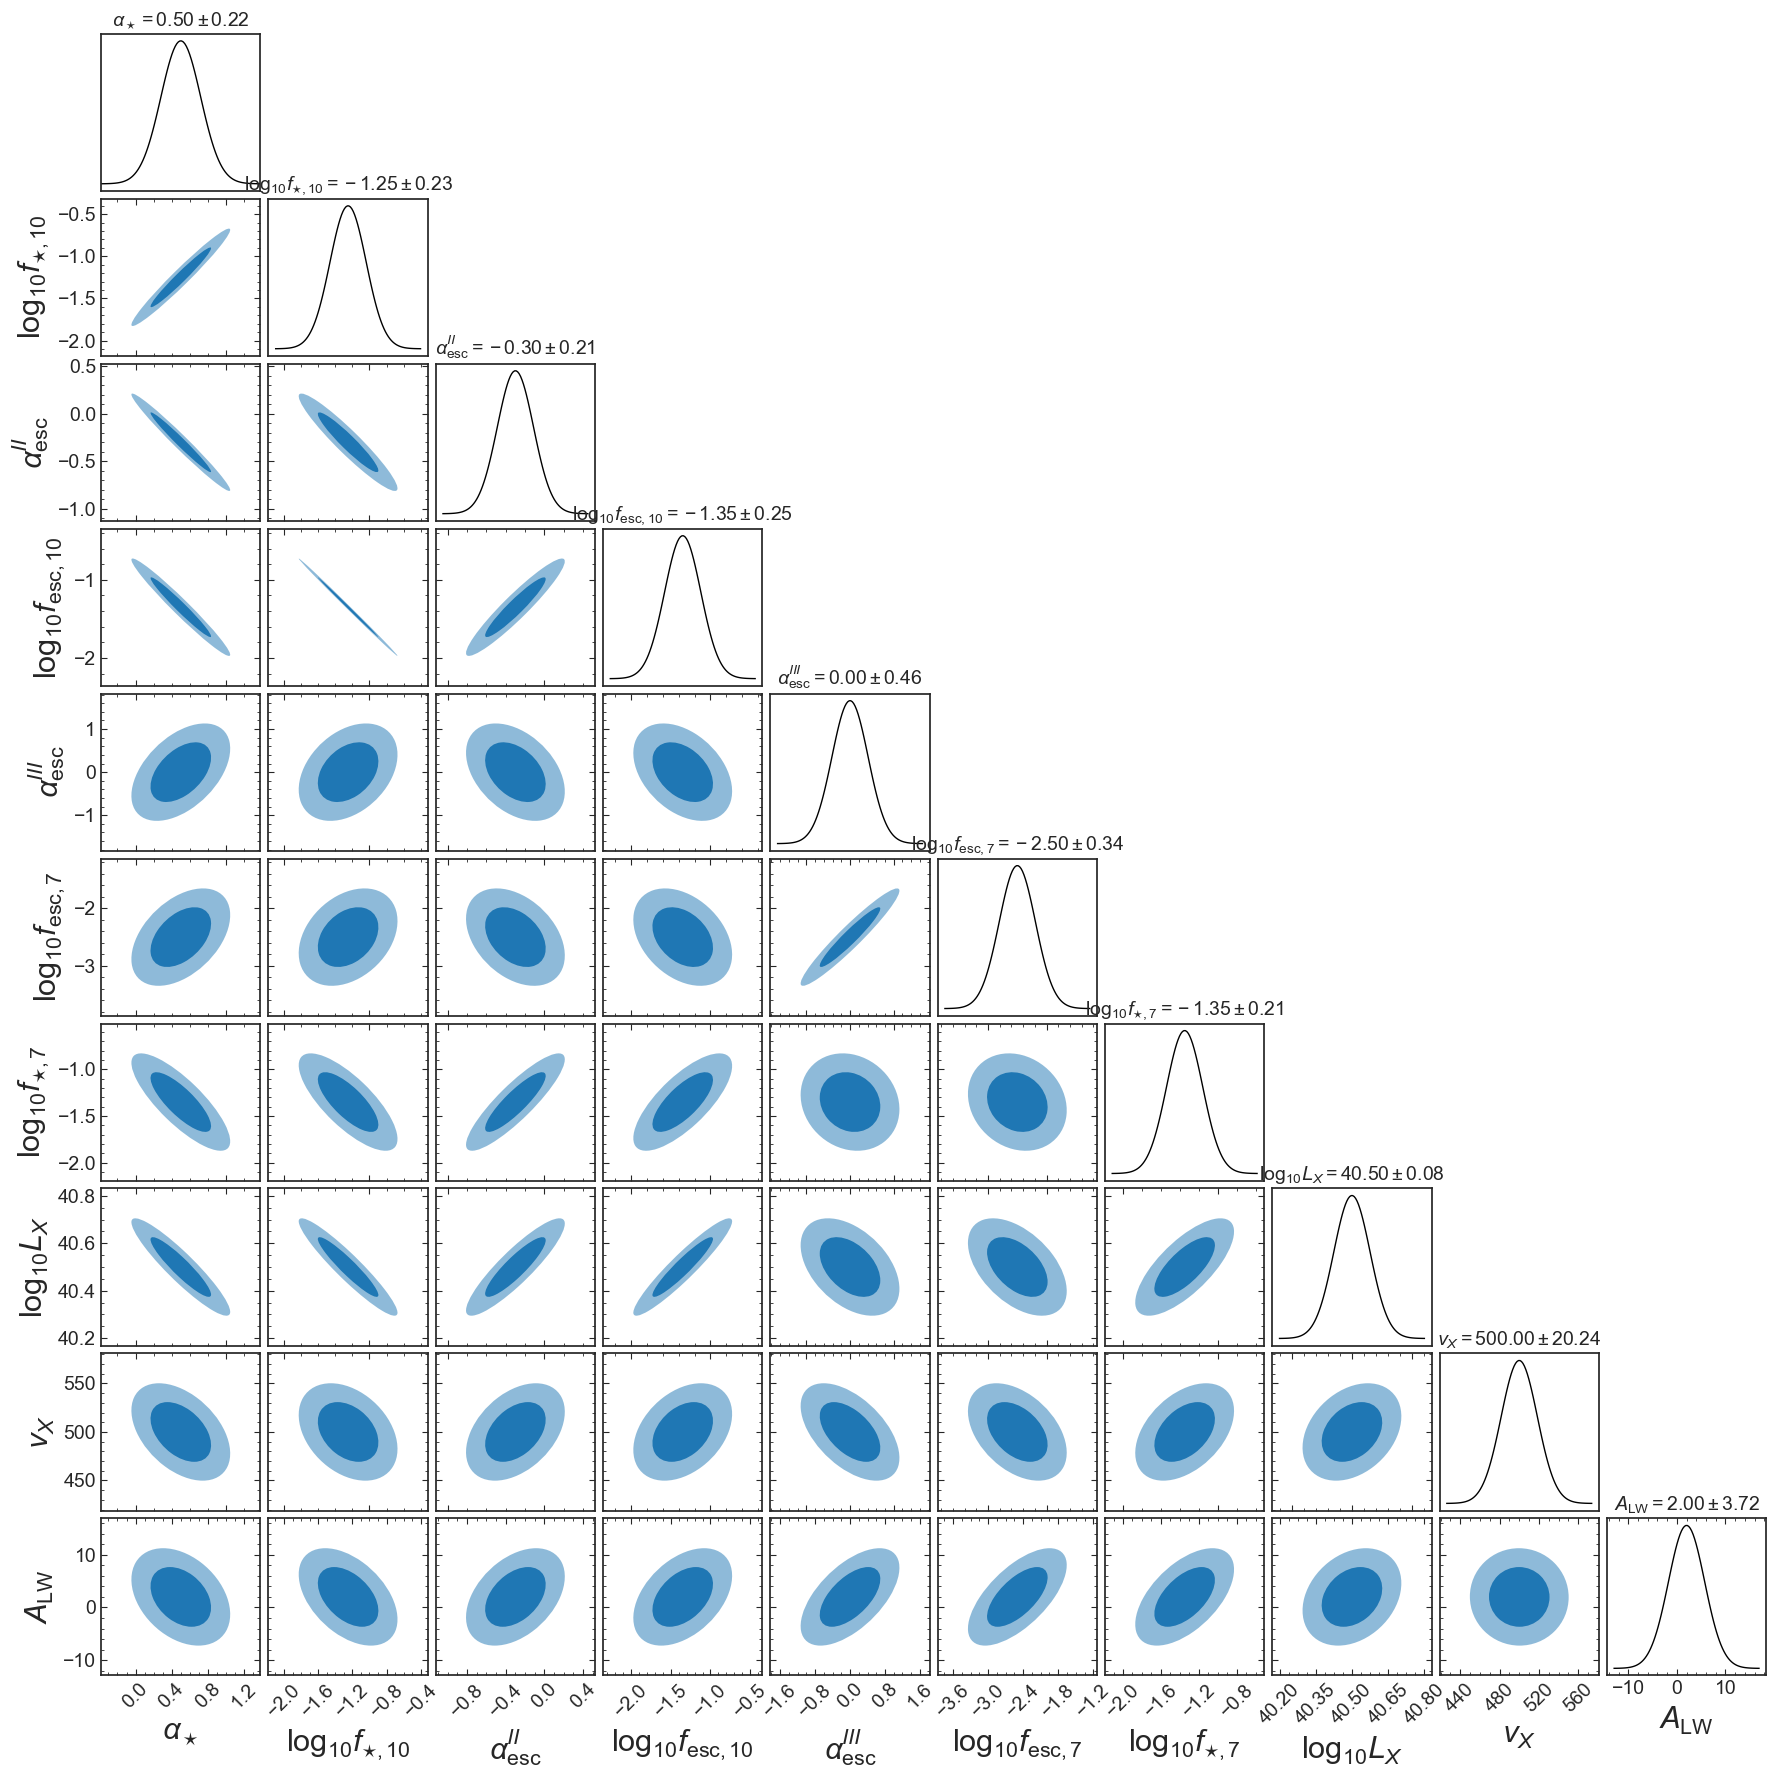

In [9]:
p21fish.plot_triangle(params=astro_params_vary, 
                      fiducial=fid_params,
                      labels=fid_labels,
                      cov=Finv_PS,
                      title_fontsize=14,
                      xlabel_kwargs={'labelpad': 5, 'fontsize':22},
                      ylabel_kwargs={'labelpad': 5, 'fontsize':22},
                      fig_kwargs={'figsize':(18,18)});

plt.savefig(examples_dir+'corner_EoS_mini_fisher.png', bbox_inches='tight')

# Comparison to Park+19

Compare Fisher matrix with [Park+2019](https://ui.adsabs.harvard.edu/abs/2019MNRAS.484..933P/abstract) fiducial to their MCMC (21cm power spectrum only)

In [10]:
output_dir_Park19 = data_dir+'Park19/'
PS_err_dir_Park19 = noise_dir+'21cmSense_noise_Park19/'
        
astro_params_vary_Park19, astro_params_fid_Park19 = p21fish.get_params_fid(
                                                    config_file=p21fish.base_path+'21cmFAST_config_files/Park19.config')

# Reorder to match Park+19
astro_params_vary_Park19 = ['F_STAR10', 'ALPHA_STAR',
                             'F_ESC10', 'ALPHA_ESC', 
                             'M_TURN', 't_STAR', 
                             'L_X', 'NU_X_THRESH']

In [11]:
# Load parameters
params_Park19 = {}
for param in astro_params_vary_Park19:
        
    params_Park19[param] = p21fish.Parameter(param=param, 
                                             output_dir=output_dir_Park19,
                                             HII_DIM=128, BOX_LEN=250,
                                             min_redshift=5.9,
                                             PS_err_dir=PS_err_dir_Park19,
                                             clobber=False, Park19='real')

########### fisher set up for F_STAR10
    Loaded redshifts
    Loaded redshifts
    Loaded T(z) from /h/hobnob0/Reionization_models/21cmfish/examples/data/Park19/global_signal_dict_F_STAR10.npy
    Loaded param values from /h/hobnob0/Reionization_models/21cmfish/examples/data/Park19/params_dict_F_STAR10.npy
    Loaded PS from /h/hobnob0/Reionization_models/21cmfish/examples/data/Park19/power_spectrum_dict_F_STAR10_Park19.npy
    Loading 21cmsense errors from /h/hobnob0/Reionization_models/21cmfish/examples/data/21cmSense_noise/21cmSense_noise_Park19/
    Loaded PS_z_HERA from /h/hobnob0/Reionization_models/21cmfish/examples/data/Park19/PS_z_HERA_Park19.npy shape= (12,)
    Loaded GS derivatives from /h/hobnob0/Reionization_models/21cmfish/examples/data/Park19/global_signal_deriv_dict_F_STAR10.npy
    Loaded PS derivatives from /h/hobnob0/Reionization_models/21cmfish/examples/data/Park19/power_spectrum_deriv_dict_F_STAR10_Park19.npy shape= (12, 30)
########### fisher set up for ALPHA_S

## Make Fisher matrix

In [12]:
Fij_matrix_PS_Park19, Finv_PS_Park19 = p21fish.make_fisher_matrix(params_Park19, 
                                                                fisher_params=astro_params_vary_Park19, 
                                                                hpeak=0.0, obs='PS',
                                                                k_min=0.1, k_max=1, 
                                                                z_min=5.7, z_max=30., 
                                                                sigma_mod_frac=0.2,
                                                                cosmo_key='CDM',
                                                                add_sigma_poisson=True) 

fid_params_Park19 = np.array([astro_params_fid_Park19[param] for param in params_Park19])
fid_labels_Park19 = np.array([p21fish.astro_params_labels[param] for param in params_Park19])

PS shape: (12, 23)


generating new axis


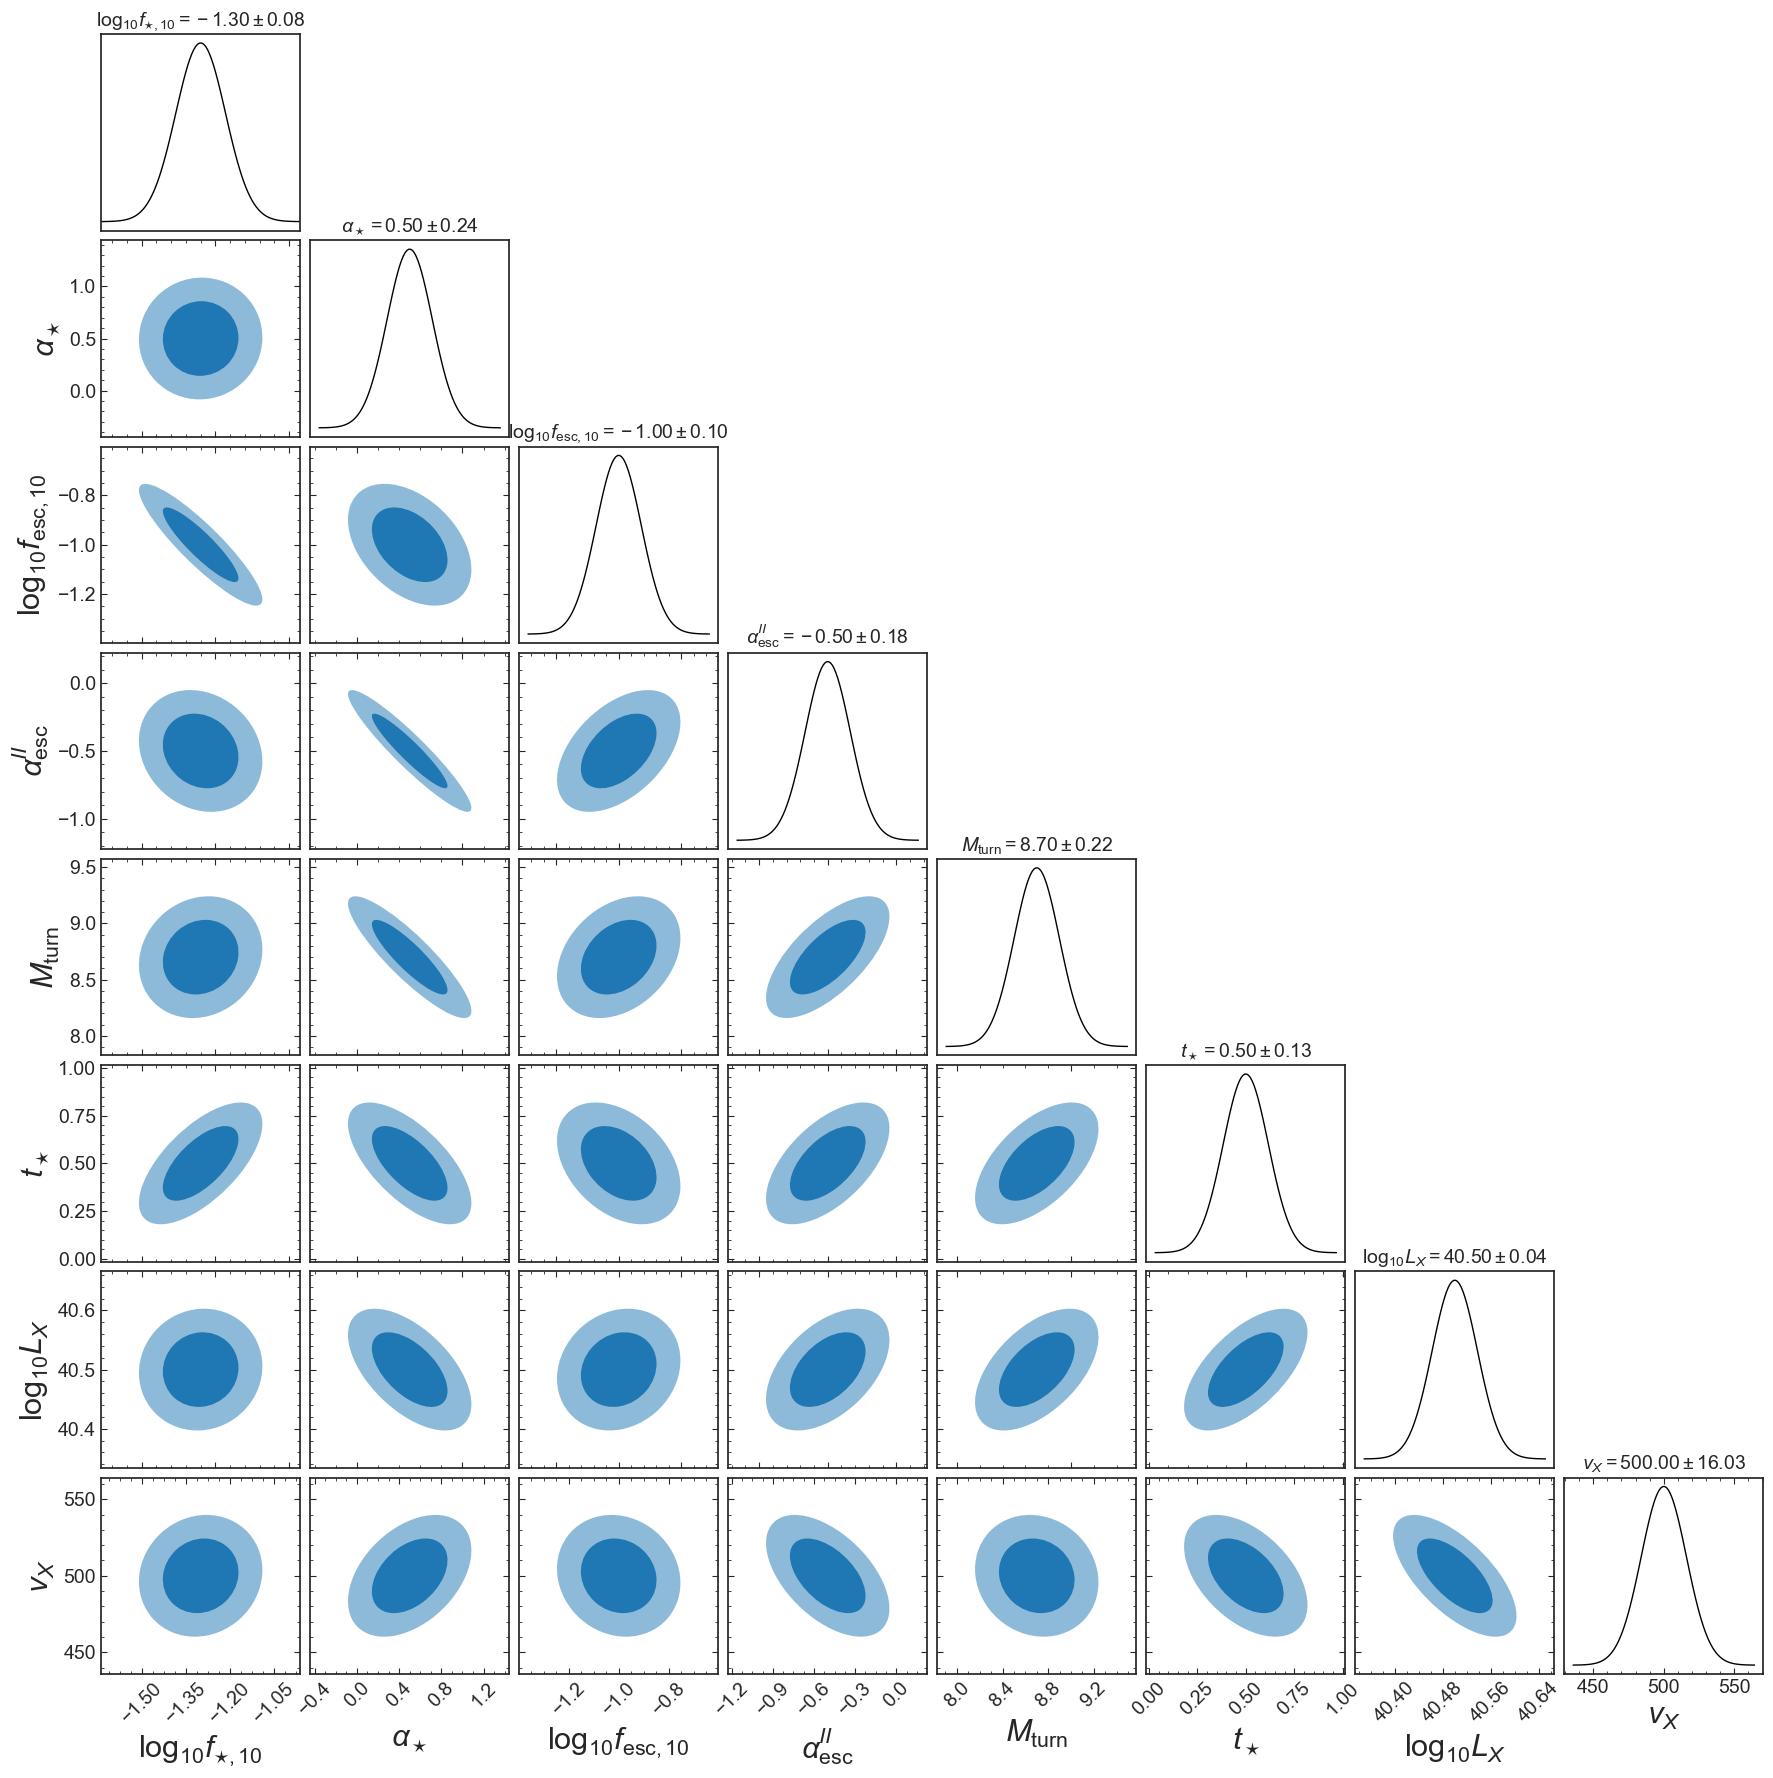

In [13]:
p21fish.plot_triangle(params=astro_params_vary_Park19, 
                      fiducial=fid_params_Park19,
                      labels=fid_labels_Park19,
                      cov=Finv_PS_Park19,
                      title_fontsize=14,
                      xlabel_kwargs={'labelpad': 5, 'fontsize':22},
                      ylabel_kwargs={'labelpad': 5, 'fontsize':22},
                      fig_kwargs={'figsize':(18,18)});

plt.savefig(examples_dir+'corner_Park19_fisher.png', bbox_inches='tight')

## Load Park19 chains and compare

Load their 21cm-only chains and compare the contours

['F_STAR10' 'ALPHA_STAR' 'F_ESC10' 'ALPHA_ESC' 'M_TURN' 't_STAR' 'L_X'
 'E0']


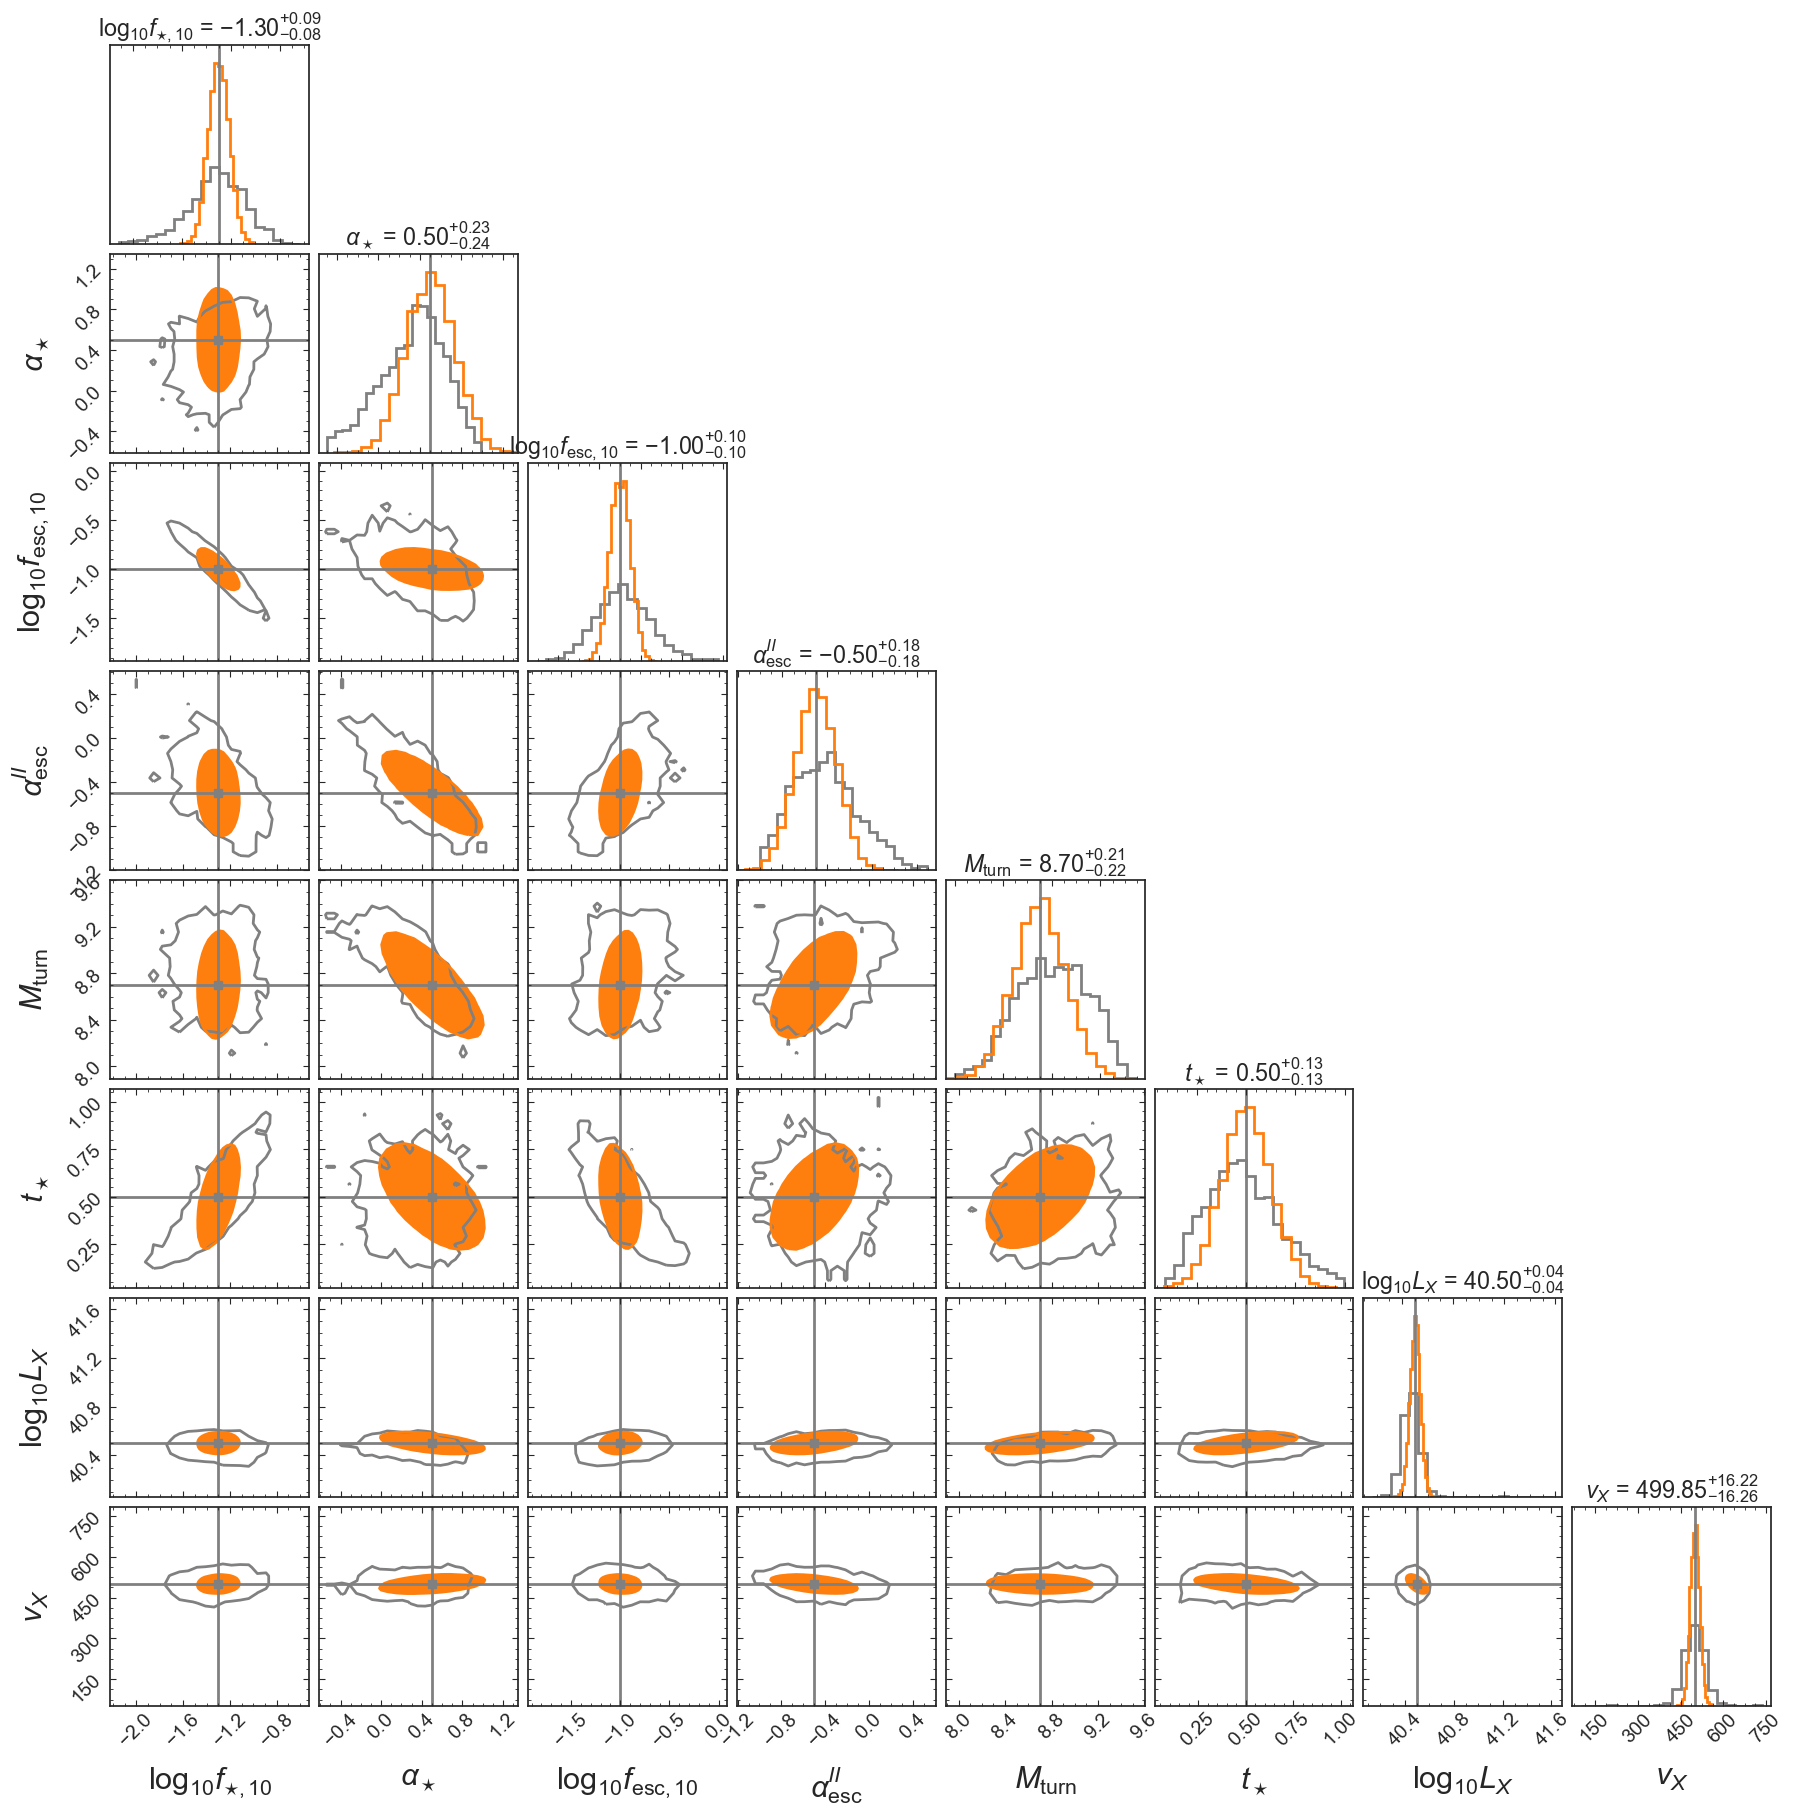

In [14]:
Park19_chains = np.load(f'{output_dir_Park19}Park19_chains.npz')
print(Park19_chains['params'])

# Make posteriors from the covariance matrix
mean = fid_params_Park19.copy()
cov  = Finv_PS_Park19.copy()
fisher_chain = np.random.multivariate_normal(mean, cov, size=10000)

# Plot 2 sigma confidence interval (https://corner.readthedocs.io/en/latest/pages/sigmas.html)
levels = 1.0 - np.exp(-0.5 * np.array([2,]) ** 2)

fig = plt.figure(figsize=(18,18))

# Corner plot
corner.corner(Park19_chains['chains'], fig=fig,              
            labels=fid_labels_Park19,
            smooth=None,
            color='0.5', use_math_text=True,
            plot_datapoints=False, plot_density=False, fill_contours=False,
            hist_kwargs = {'lw':2,'density':True},
            levels=levels,
#             range=[1,1,1,1,1,1,(40.,41.),(300,700)], # throws out a couple of outlier points in the chains
            show_titles=True,
            truths=mean, truth_color='0.5',
            );

corner.corner(fisher_chain, fig=fig,
                labels=fid_labels_Park19,
                smooth=1,
                color='tab:orange', use_math_text=True,
                plot_datapoints=False, plot_density=False, fill_contours=True,
                hist_kwargs = {'lw':2,'density':True},
                levels=levels,
                show_titles=True, 
                label_kwargs={"fontsize": 22},
             );

plt.savefig(examples_dir+'corner_Park19_fisher_compare.png', bbox_inches='tight')

# Adding a new parameter

If you want to add your own new parameter, you should:

1. Create lightcones varying that parameter.
    1. Create a config file for the parameters you want to change (take one of the examples in `../21cmFAST_config_files/` and replace the `astro_params_vary` list with your list of new parameters.
    2. Note that the fiducial parameter value for your new parameter will be the 21cmFAST default unless the fiducial value is specified in the config file. If you want a non-default fiducial parameter value you will need to create a new set of lightcones with your parameter's fiducial included in `astro_params`.
    3. Create the lightcones using `scripts/make_lightcones_for_fisher.py`
2. Load your new parameter by adding it to the dictionary [as above](#EOS21)

See more details on running `scripts/make_lightcones_for_fisher.py` in the [docs](https://21cmfish.readthedocs.io/en/latest/usage.html) 